In [28]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [29]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [30]:
from langgraph.graph import StateGraph 
from langgraph.graph import START, END

In [31]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

In [32]:
from langchain_teddynote.tools.tavily import TavilySearch

In [33]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage, ToolMessage

In [34]:
from langchain_openai import ChatOpenAI

In [35]:
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import display_message_tree
from langchain_core.runnables import RunnableConfig

In [36]:
from langgraph.checkpoint.memory import MemorySaver
import json

memory = MemorySaver()

In [37]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [38]:
######### 2. 도구 정의 및 바인딩 #########

search_tool = TavilySearch(max_results=1)

In [39]:
tools = [search_tool]

In [40]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

In [41]:
llm_with_tools = llm.bind_tools(tools)

In [42]:
def chatbot(state: State):
    print('===== chatbot() 함수 시작 =====')
    
    print("[1] chatbot() 으로 넘어온 메시지: ")

    message_type1 = ''

    for msg in state['messages']:
        if isinstance(msg, HumanMessage):
            message_type1 = message_type1 + '[HumanMessage]'
        elif isinstance(msg, AIMessage):
            message_type1 = message_type1 + '[AIMessage]'
        elif isinstance(msg, ToolMessage):
            message_type1 = message_type1 + '[ToolMessage]'
        
        print(f'메시지 타입: {message_type1}')
        print(msg)
        print()

    print(f"\n[2] 메시지 개수 : {len(state['messages'])}\n")

    answer = llm_with_tools.invoke(state['messages'])

    # print(f'[도구 사용 LLM 실행 결과 content]: {answer.content}')
    
    print('[3] chatbot()에서 실행:')
    print('메시지 타입: ', end='')

    message_type2 = ''
    if isinstance(answer, AIMessage):
        message_type2 = message_type2 + '[AIMessage]'
    elif isinstance(answer, HumanMessage):
        message_type2 = message_type2 + '[HumanMessage]'
    elif isinstance(answer, ToolMessage):
        message_type2 = message_type2 + '[ToolMessage]'
    else:
        message_type2 = type(answer)

    print(message_type2)
    print(answer)
    print()

    answer_value = {'messages': [answer]}

    print(f"[4] chatbot()에서 실행 후 메시지 개수: {message_type1} {message_type2} {len(state['messages']) + len(answer_value)}") 
    print('===== chatbot() 함수  끝 =====')
    print()

    return answer_value

In [43]:
graph_builder = StateGraph(State)

In [44]:
graph_builder.add_node('chatbot', chatbot)

In [45]:
tool_node = ToolNode(tools=[search_tool])

In [46]:
graph_builder.add_node('tools', tool_node)

In [47]:
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

In [48]:
######### 5. 엣지 추가 #########

# tools 에서 chatbot 으로
graph_builder.add_edge('tools', 'chatbot')

In [49]:
# START 에서 chatbot 으로
graph_builder.add_edge(START, 'chatbot')

In [50]:
# chatbot 에서 END 로
graph_builder.add_edge('chatbot', END)

In [51]:
graph = graph_builder.compile(checkpointer=memory)

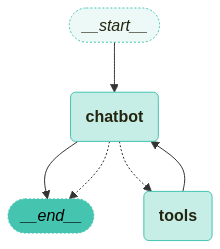

In [52]:
visualize_graph(graph)

In [53]:
from langchain_teddynote.graphs import generate_random_hash
from langchain_core.runnables import RunnableConfig

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

thread_id: d90bd3


In [54]:
config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': thread_id}
)

question = ('랭체인에 대해서 검색해주세요')


for event in graph.stream({"messages": [("user", question)]}, config=config):
    print()
    print('========================= 여기서 시작 ====================')
    print(f'[event] 바깥 for 시작')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print()

        if isinstance(value['messages'][-1], HumanMessage):
            print('==================== HumanMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            print(f"[해당 노드 값] content: {value['messages'][-1].content}")
            print('==================== END HumanMessage ====================')
            print()
        elif isinstance(value['messages'][-1], AIMessage):
            print('==================== AIMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            print(f"[해당 노드 값] content: {value['messages'][-1].content}")

            if hasattr(value['messages'][-1], 'tool_calls') and len(value['messages'][-1].tool_calls) > 0:
                print('tool call 있음')

                tool_result = value['messages'][-1].tool_calls

                print(f"도구 이름 : {tool_result[0]['name']}")
                print(f"도구 인자: {tool_result[0]['args']}")            
            else:
                print('tool call 없음')                
            print('==================== END AIMessage ====================')    

        elif isinstance(value['messages'][-1], ToolMessage):
            print('==================== ToolMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            # print(f"[해당 노드 값] content : \n{value['messages'][-1].content}")
            # print(f"[해당 노드 값] 도구 name : {value['messages'][-1].name}")
            print(f"[해당 노드 값] 도구 도구 이름 : {value['messages'][-1].name}")

            content = json.loads(value['messages'][-1].content)

            if content and isinstance(content, list) and len(content) > 0:                
                print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")                
            else:
                print("No content or invalid content format in ToolMessage")

            print('==================== END ToolMessage ====================')   

        print()
    

    print('바깥 for 끝')
    print('========================= 여기서 끝 =========================') 
    print()

===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
메시지 타입: [HumanMessage]
content='랭체인에 대해서 검색해주세요' additional_kwargs={} response_metadata={} id='cca4474b-456f-418b-8eed-aa627d63fde5'


[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_YCVt6pz46uurtfOvP5sD33DH', 'function': {'arguments': '{"query":"랭체인"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 99, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-0d5fc64a-f80c-4def-a18e-9c2daffc2caf-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭체인'}, 'id

In [55]:
thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': thread_id}
)

question = ('랭체인에 대해서 뉴스 검색을 해주세요')

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

thread_id: 581ac5
===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
메시지 타입: [HumanMessage]
content='랭체인에 대해서 뉴스 검색을 해주세요' additional_kwargs={} response_metadata={} id='e9266737-d9a7-4e52-b658-037a01461fb7'


[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_xcPU7TGABh1j5hNbpjkSdgpA', 'function': {'arguments': '{"query":"랭체인"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 102, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-707b8cce-088b-4f06-bc08-340242b15c57-0' tool_calls=[{'name': 'tavily_web_search', 'args

In [56]:
question = ('랭체인에 대해서 웹 검색을 해주세요')

for event in graph.stream({"messages": [("user", question)]}, config=config):
    print('==' * 50)
    print('[event]')
    # print(event)

    for key, value in event.items():
        value['messages'][-1].pretty_print()

===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
메시지 타입: [HumanMessage]
content='랭체인에 대해서 뉴스 검색을 해주세요' additional_kwargs={} response_metadata={} id='e9266737-d9a7-4e52-b658-037a01461fb7'

메시지 타입: [HumanMessage][AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_xcPU7TGABh1j5hNbpjkSdgpA', 'function': {'arguments': '{"query":"랭체인"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 102, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-707b8cce-088b-4f06-bc08-340242b15c57-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭체인'}, 'id': 'call_xcPU7TGA

In [57]:
from langchain_teddynote.graphs import generate_random_hash
from langchain_core.runnables import RunnableConfig

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': thread_id}
)

question = ('랭체인에 대해서 웹 검색을 해주세요')

i = 1

for event in graph.stream({"messages": [("user", question)]}, config=config):
    print()
    print('===== 여기서 시작 =====')
    print(f'[event] 바깥 for 시작 {i}')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print()

        if isinstance(value['messages'][-1], HumanMessage):
            print('==================== HumanMessage ========================')
            print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            # print(f"[해당 노드 값] content: {value['messages'][-1].content}")
            # print(f"additional_kwargs: {value['messages'][-1].additional_kwargs}")
            print('==================== END HumanMessage ====================')
            print()
        elif isinstance(value['messages'][-1], AIMessage):
            print('==================== AIMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            print(f"[해당 노드 값] value content: {value['messages'][-1].content}")
            # print(f"addtional_kwargs: {value['messages'][-1].additional_kwargs}")

            if 'tool_calls' in value['messages'][-1].additional_kwargs:
                # print(f"additional_kwargs tool_calls: {value['messages'][-1].additional_kwargs['tool_calls']}")
                tool_calls = value['messages'][-1].additional_kwargs['tool_calls']

                for call in tool_calls:
                    if 'function' in call:
                        arguments = json.loads(call['function']['arguments'])
                        name = call['function']['name']

                        print(f"도구 이름 : {name}")
                        print(f"Arguments: {arguments}")
            else:
                print("additional_kwargs tool_calls: None")
            print('==================== END AIMessage ====================')    

        elif isinstance(value['messages'][-1], ToolMessage):
            print('==================== ToolMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            content = json.loads(value['messages'][-1].content)

            if content and isinstance(content, list) and len(content) > 0:
                print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")
            else:
                print("No content or invalid content format in ToolMessage")

            print('==================== END ToolMessage ====================')   

        print()
        
    print('바깥 for 끝')
    i=i+1
    
    print('===== 여기서 끝 =====') 
    print()
print(f'전체 반복문 {i}번 실행')    

thread_id: eb0046
===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
메시지 타입: [HumanMessage]
content='랭체인에 대해서 웹 검색을 해주세요' additional_kwargs={} response_metadata={} id='6b291d6a-de36-4203-ba27-393961818749'


[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_uGcJUwmX7Ur30t7pkTKbw8nP', 'function': {'arguments': '{"query":"랭체인"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 102, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-ce77a75c-f118-4642-8283-a9350b727c19-0' tool_calls=[{'name': 'tavily_web_search', 'args'